2020-05-26 v1 LSW@NCHC

2020-08-13 v2

2020-08-31 v3_tf.data_Loadandpreprocessdata_image_tf2.3to2.2_twcc_clean


### 2020-08-31 <font color=#FF6600>Move to 'clean NB' for trail, leave original NB for course used.</font>

### 2020-09-14 <font color=#FF6600>Fixed BN in fine-tune training, added dropout at top-layer.</font>
### 2020-09-16 <font color=#FF6600>Added tf.distribute.Strategy with multi-GPUs for speedup training.</font>
### 2020-09-17 <font color=#FF6600>Added step learning rate, tensorboard callback.</font>
### 2020-09-18
### 2020-09-19 <font color=#FF6600>Re write with tensorboard embedding project.</font>

# <font color=#0019ff>Transfer Learning with Embedding Projector in TensorBoard.</font>

tf.keras.layers.Embedding() --> for text/word

So, for image feature embedding

* 1. vecs.tsv : the high dimension feature vector of the image, predicted from the pre-train feature extractor model (without the classfication layer).

* 2. meta.tsv : the label of example (test image), reload form batch of val_ds_pre (tf.data).

* 3. sprite_image.png: the collection of image grid of example. Extracted from the val_ds_pre.

TensorBoard 的 sprite image 大小極限是8192x8192px [need to check]


#### <font color=#0099ff>1.2.3.均可離線產生只是把檔案寫進TB而已。vectors即model pred結果，但是取dense layer，不是分類結果。</font>.

` Load 


#### 全離線作法，將vector, meta, sprite 寫入

```
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)```

## 0. Install pkgs for TWCC

In [ ]:
#!sh install_env.sh

## 1. Download dataset

In [1]:
from datetime import datetime

import tensorflow as tf
from tensorboard.plugins import projector

# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
import vlogging


print("tf version : ", tf.__version__)

# 下載資料,(flower ~218MB)
# keras下載位置預設為~/user/.keras/datasets/
# !ls /Users/lsw/.keras/datasets/flower_photos
# LICENSE.txt daisy  dandelion  roses  sunflowers  tulips

# flood
# origin = 'https://drive.narlabs.org.tw/webrelay/directdownload/txp8hb31v67tl47f/?dis=10014&fi=2683826'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='floods', untar=True)

# flowers
# origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True)
# data_dir = '/home/uu/.keras/datasets/flower_photos' #不下載，直接sftp上傳

# uni
data_dir = '/home/uu/.keras/datasets/uni' #不下載，直接sftp上傳

data_dir = pathlib.Path(data_dir) # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。
image_count = len(list(data_dir.glob('*/*.jpg')))
#CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')])
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

# todo:這裡可以幫學員回憶python強大的表示式處理


# data information
print("Save to :", data_dir)
print("Count images: ", image_count)
print("Class names : ", class_names)
print("Class number: ", len(class_names))

tf version :  2.2.0
Save to : /home/uu/.keras/datasets/uni
Count images:  5620
Class names :  ['ng' 'ok']
Class number:  2


In [2]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('sunflowers/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

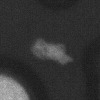

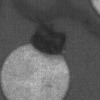

In [3]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('ng/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

In [4]:
# vars
BATCH_SIZE = 32 #32 
img_height = 100 #100
img_width = 100 #100
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

#IMG_SIZE = (224, 224) # IMG_SIZE = (160, 160)

## 2. Load dataset with tf.data


In [5]:
# 以tf.data來讀取資料
# 同樣地，給定本地資料集的路徑。
# 2020-06-11版本(相同)
"""tf.data.Dataset.list_files
Note: The default behavior of this method is to return filenames in 
a non-deterministic random shuffled order. Pass a seed or shuffle=False 
to get results in a deterministic order.預設為random shuffle"""

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [6]:
# 檢查路徑、檔案

for f in list_ds.take(10):
  print(f.numpy())

b'/home/uu/.keras/datasets/uni/ng/CSPAFI#4_19CJ2029-01-000_1_NG014_Panel0012_ProcA4_Shot0_V24_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-05-000_1_NG010_Panel0013_ProcA3_Shot0_V23_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_1_NG006_Panel0022_ProcA3_Col#1_Shot0_V1_D1_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-05-000_1_NG011_Panel0001_ProcA3_Shot0_V20_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#4_19CJ2029-01-000_1_NG007_Panel0022_ProcA3_Shot0_V19_D1_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-05-000_1_NG009_Panel0017_ProcA3_Shot0_V3_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-02-000_1_NG003_Panel0003_ProcA4_Shot0_V5_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ng/CSPAFI-C#3_19CC2018-04-000_1_NG004_Panel0014_ProcA3_Col#1_Shot0_V3_D3_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-05-000_1_NG010_Panel0022_ProcA4_Shot0_V16_D1_Img.jpg'
b'/home/uu/.keras/datasets/uni/ng/

hit: 觀察有無shuffle變化

In [7]:
#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['ng' 'ok']


hit: 這裏可以請同學練習list基本原理與操作，往後資料呈現都會是以多維list or array方式。

hit:列表產生式與產生器的不同，`[] and ()`使用差異。

### Split the dataset into train and validation:

In [8]:
# train 80, val 20
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)



In [9]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

4498
1124


In [10]:
for t,v in zip(train_ds.take(2),val_ds.take(2)):
  print(t.numpy(), '\n')
  print(v.numpy())


b'/home/uu/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-02-000_1_NG013_Panel0008_ProcA4_Shot0_V0_D0_Img.jpg' 

b'/home/uu/.keras/datasets/uni/ng/CSPAFI#4_19CJ2029-01-000_1_NG014_Panel0012_ProcA4_Shot0_V24_D0_Img.jpg'
b'/home/uu/.keras/datasets/uni/ok/CSPAFI#6_19CJ2028-02-000_1_NG018_Panel0001_ProcA3_Shot0_V11_D0_Img.jpg' 

b'/home/uu/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-05-000_1_NG010_Panel0013_ProcA3_Shot0_V23_D0_Img.jpg'


In [11]:
#J Save train/val path list for later used

# len(list(val_ds))#1124 images for val_ds

count = 0
for element in val_ds.take(2):
    print(element) #tf.Tensor(b'/home/uu/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-05-000_1_NG011_Panel0006_ProcA3_Shot0_V5_D0_Img.jpg', shape=(), dtype=string)
    parts = tf.strings.split(element, os.path.sep)
    print('parts[] =', parts[-2]) # [-2]= dir name, [-1]= file name.
    count += 1   
print(count)
    

tf.Tensor(b'/home/uu/.keras/datasets/uni/ng/CSPAFI#4_19CJ2029-01-000_1_NG014_Panel0012_ProcA4_Shot0_V24_D0_Img.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'ng', shape=(), dtype=string)
tf.Tensor(b'/home/uu/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-05-000_1_NG010_Panel0013_ProcA3_Shot0_V23_D0_Img.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'ng', shape=(), dtype=string)
2


### Converts a file path to an (img, label) pair:

In [12]:
#J tf2.3新版load_data/images使用one-hot, 所以後面的training 要把sparse_categorical_crossentropy換掉，變傳統的one-hot/categorical loss.
#新版：tf2.3
#
#J modify the get_label for runing at tf2.2 2020-08-06 2020-08-11 OKfortf2.2
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num
#     return tf.argmax(one_hot)
#   return tf.math.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label



# hit: 請學員參考寫註解(英文)的方式，清晰易讀。中文註解主要作為課程說明與程式註解用途不同。

In [13]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds_map = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_map = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)



one_num: Tensor("ArgMax:0", shape=(), dtype=int64)
one_num: Tensor("ArgMax:0", shape=(), dtype=int64)


## 3. configure_for_performance_cache tf.data

In [14]:
#J
#新版：簡化很多
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(BATCH_SIZE)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))

def configure_for_performance_cache(ds, cache=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
      print("Check cache to file:", cache)
    else:
      ds = ds.cache()
      print("Check cache in memory:", cache)
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
BATCH_SIZE: 32, MULTI_BATCH_SIZE: 32


hit:

    ds.shuffle(buffer_size=1000)
    表示buffer維持一千張圖，隨機抽掉一張後，會由1001張補進維持1K張。因此完美的洗牌建議buffer要大於或等於dataset數量。

In [15]:
#J 新版：
train_ds_pre = configure_for_performance_cache(train_ds_map)
val_ds_pre = configure_for_performance_cache(val_ds_map)


Check cache in memory: True
Check cache in memory: True


### Visualize the data
You can visualize this dataset similarly to the one you created previously.

label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)


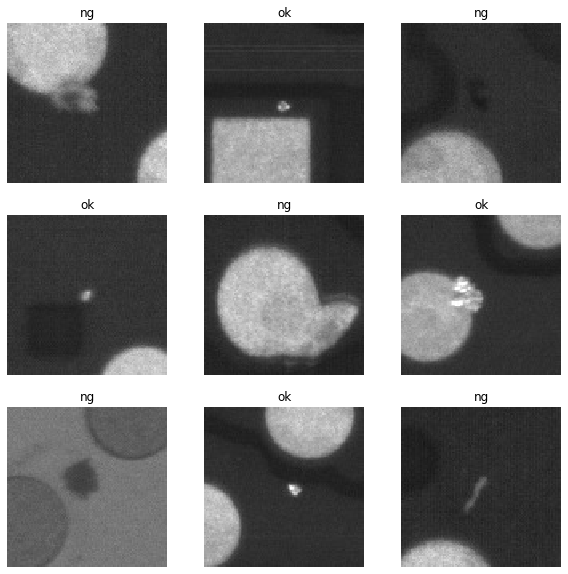

In [16]:
#J 新版：tf2.3

image_batch, label_batch = next(iter(train_ds_pre))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  print('label from label_batch:', label)
  plt.title(class_names[label])
  plt.axis("off")

In [17]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [20]:
#====================================================================================================#

In [21]:
#====================================================================================================#

## Load pre-trained model

In [20]:
#Loading the model back:
current_model_name = 'uni_Xception_top100_bs64_w100h100_e200_acc0.9108_2020-09-19-15-12.h5'
model_back = tf.keras.models.load_model(current_model_name)

In [21]:
%%time
loss, accuracy = model_back.evaluate(val_ds_pre)
# print('Test accuracy :', accuracy)

print("count roughly ds size: ", tf.data.experimental.cardinality(val_ds_pre).numpy() * BATCH_SIZE)

36/36 [==============================] - 1s 22ms/step - loss: 0.2240 - accuracy: 0.9093
count roughly ds size:  1152
CPU times: user 5.15 s, sys: 2.1 s, total: 7.25 s
Wall time: 6.66 s


### 'It seems that different shuffle makes validation accuracy varies.'

In [22]:
'Restart and Ruan All'

36/36 [==============================] - 0s 12ms/step - loss: 0.2655 - accuracy: 0.8932
roughly ds size:  1152
CPU times: user 425 ms, sys: 70.8 ms, total: 496 ms
Wall time: 485 ms

36/36 [==============================] - 1s 25ms/step - loss: 0.2461 - accuracy: 0.9039
roughly ds size:  1152
CPU times: user 4.73 s, sys: 1.36 s, total: 6.09 s
Wall time: 6.73 s

36/36 [==============================] - 1s 25ms/step - loss: 0.2514 - accuracy: 0.9021
roughly ds size:  1152
CPU times: user 4.87 s, sys: 1.48 s, total: 6.35 s
Wall time: 6.99 s

'It seems that different shuffle makes validation accuracy varies.'

SyntaxError: invalid syntax (<ipython-input-22-66342cbe968e>, line 3)

## 0. Set Tensorboard directory

In [24]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/embedding-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

## Embedding
## 1. (vecs.tsv) to tf.Variable 
#### Create the vecs.tsv from the pre-trained model with its dense layer's output.

In [ ]:
model_back.summary()

In [ ]:
for l in model_back.layers:
    print(l)

In [ ]:
layer_name = 'global_average_pooling2d_8' # 'dense_8'

intermediate_layer_model = tf.keras.Model(model_back.input, model_back.get_layer(layer_name).output, name='model_intermediate_layer')
intermediate_output = intermediate_layer_model.predict(val_ds_pre)


In [ ]:
intermediate_layer_model.summary()

In [ ]:
intermediate_output.shape

In [ ]:
len(intermediate_output)

In [ ]:
len(intermediate_output[1])

In [ ]:
print(intermediate_output)

In [ ]:
np.savetxt('output-gap-2048.txt', intermediate_output)
'''1124*2048*float32 ~ 55MB'''

In [ ]:
!ls -lh out*

In [ ]:
# vectors: from dense 2018
vectors = tf.Variable(intermediate_output, name='dense vectors')

In [ ]:
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=vectors)
checkpoint.save(os.path.join(log_dir, "embedding-vectors.ckpt"))

In [ ]:
#====================================================================================================#

## 2. meta.tsv (Label of examples)
#### Create the meta.tsv from val_ds_pre.

In [ ]:
%%time
out_m = open(os.path.join(log_dir, 'metadata.tsv'), 'w', encoding='utf-8')
for image_batch, label_batch in val_ds_pre: 
#     for i in range(BATCH_SIZE):
    [out_m.write(str(class_names[x.numpy()]) + "\n") for x in label_batch]
out_m.close()

In [ ]:
'''
%%time

# 教材：中間休息時練習，20mins先自行寫一版來比較課堂版速度差異跟行數。注意有warmup差異。

# ------------------ 省時的寫法 ------------------ #

out_m = open(os.path.join(log_dir, 'metadata.tsv'), 'w', encoding='utf-8')
for image_batch, label_batch in val_ds_pre: 
#     for i in range(BATCH_SIZE):
    [out_m.write(str(class_names[x.numpy()]) + "\n") for x in label_batch]
out_m.close()


# ------------------ 耗時的寫法 ------------------ #

# rewrite to prediction with batch of ds, replace the list of file to speed up.
# todo: Checked right!:model_back.predict_on_batch [OK done 20200904]

batch_n = 0
acc_count= 0

label_true_all = []
label_pred_all = []

for image_batch, label_batch in val_ds_pre: #ds set to repeat forever
    batch_n += 1
    pred_max = []
    pred = model_back.predict_on_batch(image_batch)
    
    label_batch_np = label_batch.numpy()
    label_true_all.extend(label_batch_np)
    #print('label_batch_np = ',label_batch_np)
    
    for i in range(BATCH_SIZE):
#         print(i)
        try:
            score = tf.nn.softmax(pred[i])
            label_pred = np.argmax(score)
            pred_max.append(label_pred)
            
#             print('label_batch_np[i] = ', label_batch_np[i])
            
            if label_batch_np[i] == label_pred:
                acc_count += 1
        except IndexError:
            print("End of batch", end="")
    label_pred_all.extend(pred_max)
    
    #print("pred =", pred_max)
print("acc_count =", acc_count, "  (if score == label[i] then count one.)") 
print("Number of batch used = ",batch_n)

'''

## 3. sprite image

In [227]:
%%time
# a list of image array
img_data=[]
for image_batch, label_batch in val_ds_pre: 
    #x.numpy(): convet tf.tensor to np
    [img_data.append(x.numpy()) for x in image_batch] # same as: for i in range(BATCH_SIZE):

#todo: add resize when sprite not with 100x100 just in case.

CPU times: user 343 ms, sys: 27.9 ms, total: 370 ms
Wall time: 270 ms


In [228]:
%%time
# convert image list to npy
img_npy = np.array(img_data)

CPU times: user 17.5 ms, sys: 26.3 ms, total: 43.9 ms
Wall time: 43.2 ms


In [217]:
# Taken from: https://github.com/tensorflow/tensorflow/issues/6322
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding

    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    
    #? seems they do Histogram equalization for better viewing in embedding!
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [218]:
%%time
sprite = images_to_sprite(img_npy)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprite)

CPU times: user 577 ms, sys: 178 ms, total: 755 ms
Wall time: 793 ms


True

In [219]:
sprite.shape

(3400, 3400, 3)

In [220]:
sprite.dtype

dtype('uint8')

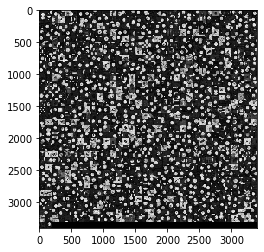

In [221]:
plt.imshow(sprite)

## 4. Set up config for TensorBoard

In [ ]:
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The sprite image
embedding.sprite.image_path = 'sprite_4_classes.png'
embedding.sprite.single_image_dim.extend([img_height, img_width])
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#